In [13]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [14]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 29) (14680,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


# Anatomy

In [15]:
import os
from anatomy import *

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

## Lasso validation

In [18]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyLassoval.bin")
    groups = {
        "lasso": ["lasso"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    return anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_mae_lasso = anatomize(xy, subsets)

data generated


### PBSV

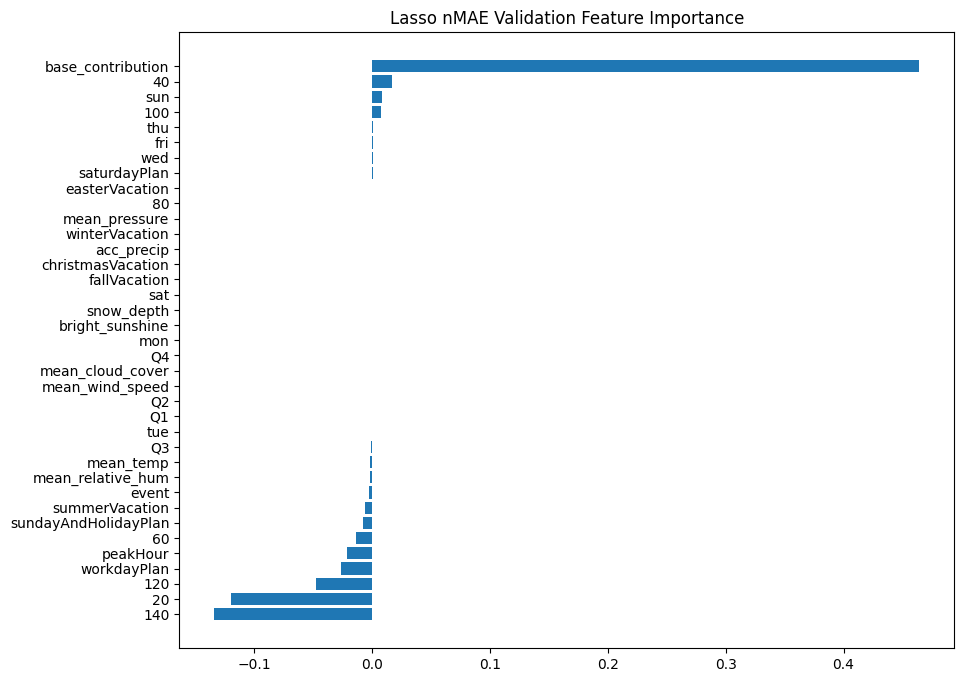

In [19]:
keys = anatomized_mae_lasso.transpose()['lasso']['14680 -> 16519'].index
values = anatomized_mae_lasso.transpose()['lasso']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Lasso nMAE')

## Random Forest validation

In [20]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyRFval.bin")
    groups = {
        "rf": ["rf"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    return anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_mae_rf = anatomize(xy, subsets)

data generated


### PBSV

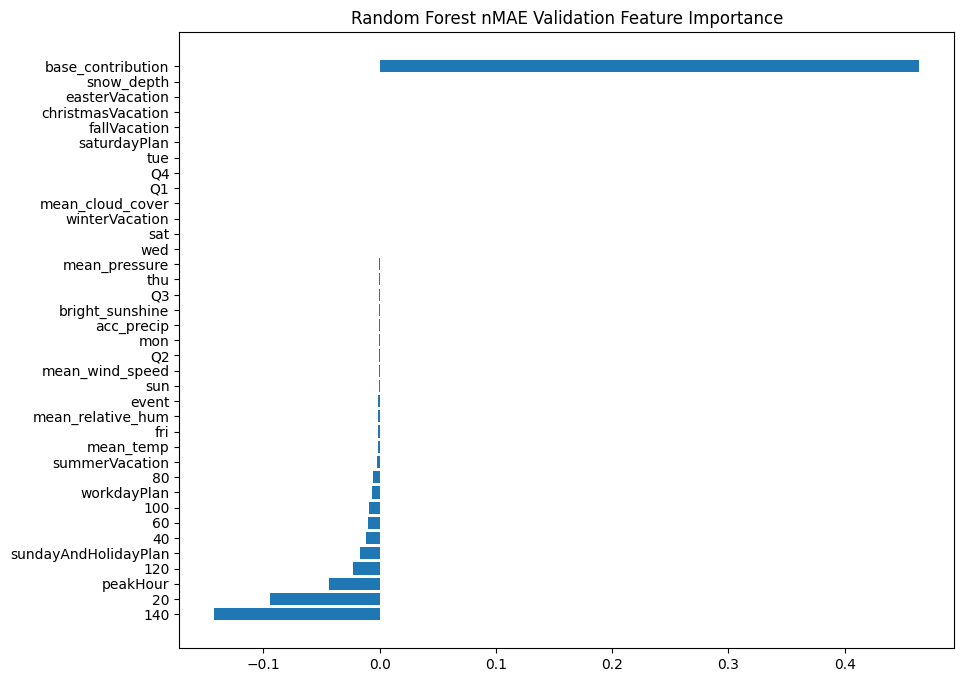

In [21]:
keys = anatomized_mae_rf.transpose()['rf']['14680 -> 16519'].index
values = anatomized_mae_rf.transpose()['rf']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'Random Forest nMAE')

## XGBoost validation

In [7]:
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyXGBval.bin")
    groups = {
        "xgb": ["xgb"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )
    
    def anatomize_raw() -> pd.DataFrame:
        def transform(y_hat):
            return y_hat

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    anatomized_mae = anatomize_mae()
    anatomized_raw = anatomize_raw()
    return anatomized_raw, anatomized_mae

np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

anatomized_raw_xgb, anatomized_mae_xgb = anatomize(xy, subsets)

data generated


### PBSV

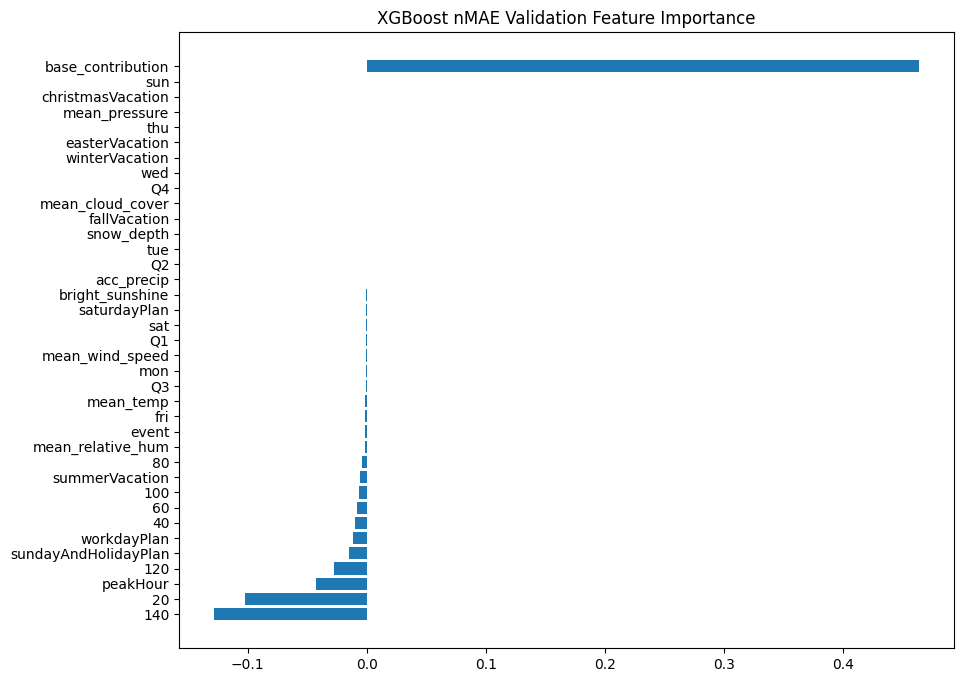

In [8]:
keys = anatomized_mae_xgb.transpose()['xgb']['14680 -> 16519'].index
values = anatomized_mae_xgb.transpose()['xgb']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'XGBoost nMAE')

### oShapley-VI

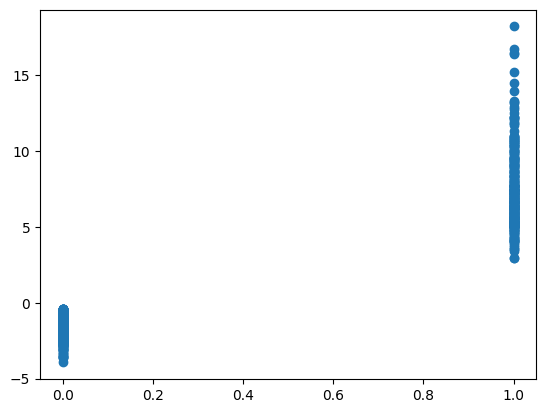

0   -1.194248
1    7.487622
Name: saturdayPlan, dtype: float64

In [9]:
variable = Columns.calendar_saturdayPlan
keys = anatomized_raw_xgb.loc['xgb'].index
values = anatomized_raw_xgb.loc['xgb'][variable.value]

plt.scatter(df_val[df_val['line'] == '1A'][variable.value].values, values)
plt.show()

values.groupby(df_val[df_val['line'] == '1A'][variable.value].values).mean()

## RNN validation

## LSTM validation